In [1]:
import torch
import torchvision

### Setup Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Get data

In [3]:
from modules.data import create_datasets, create_dataloaders

data_transforms = torchvision.models.ResNet50_Weights.DEFAULT.transforms()
root = 'data'

train_data, test_data, class_names = create_datasets(dataset=torchvision.datasets.Food101, 
                                                     download_path=root, transform=data_transforms)
train_dataloader, test_dataloader = create_dataloaders(train_data=train_data, test_data=test_data, batch_size=32)

### Define Model

In [4]:

from torch import nn
from modules.utils import load_model

weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

### Training Phase 1 - Initial Training 
#####  - Only the final fully-connected (fc) layer is unfrozen; all base layers are frozen.
#####  - Trains the classifier head on top of pretrained ImageNet features.
#####  - Used learning rate: 1e-3
#####  - No scheduler used.
#####  - Training for 15 epochs.
##### - Plot Loss and Accuracy Curves

In [ ]:
from modules.engine import train

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# UnFreeze the fc layer
model.fc = nn.Linear(in_features=2048, out_features=len(class_names), bias=True).to(device)

loss_fn = nn.CrossEntropyLoss()
tp1_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

tp1_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=15, 
                loss_fn=loss_fn, optimizer=tp1_optimizer, device=device, scheduler=None)

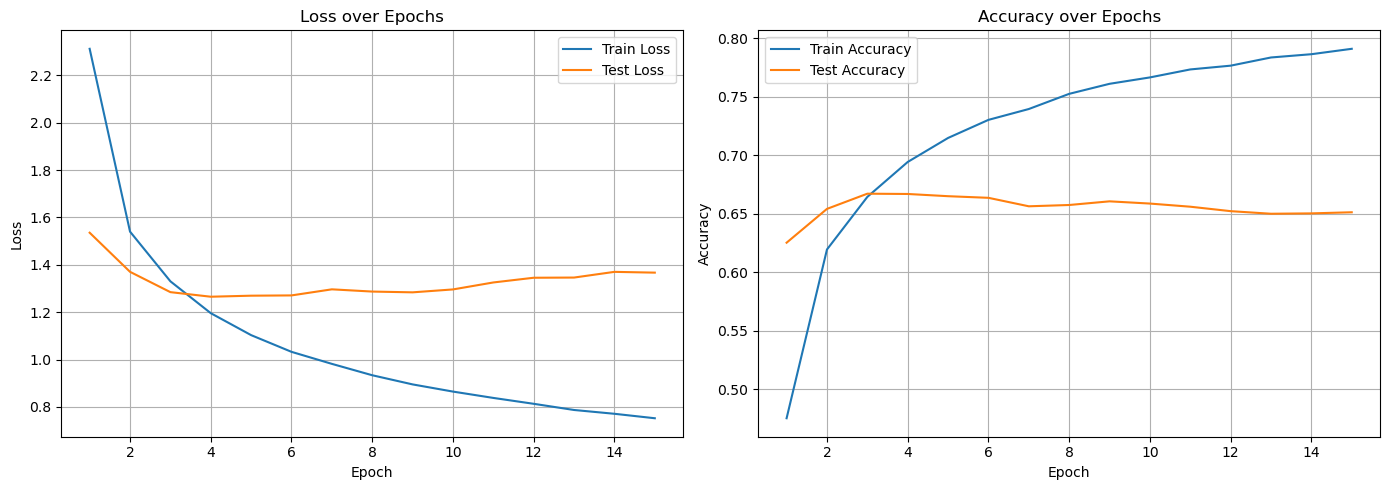

In [16]:
from modules.visualize import plot_loss_curves
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plot_loss_curves(tp1_results)

In [ ]:
from modules.utils import save_model

save_path = 'models/model_phase01.pth'
save_model(model=model, target_path=save_path)

### Training Phase 2 - Fine Tuning High Level Features
##### - Unfroze 'layer4' along with the 'fc' layer; all earlier layers remain frozen.
##### - Modify the fc layer to have dropout.
##### - Trains high-level ResNet features specific to the Food101 dataset.
##### - Used learning rate: 1e-4
##### - No scheduler used.
##### - Training for 15 epochs.
##### - Plot Loss and Accuracy Curves
##### - Goal: Allow deeper parts of the model to learn domain-specific representations.

In [ ]:
# UnFreeze the fc layer and layer 4
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modify the fc layer
model.fc = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=2048, out_features=len(class_names), bias=True)
).to(device)

tp2_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

tp2_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=15, 
                loss_fn=loss_fn, optimizer=tp2_optimizer, device=device, scheduler=None)

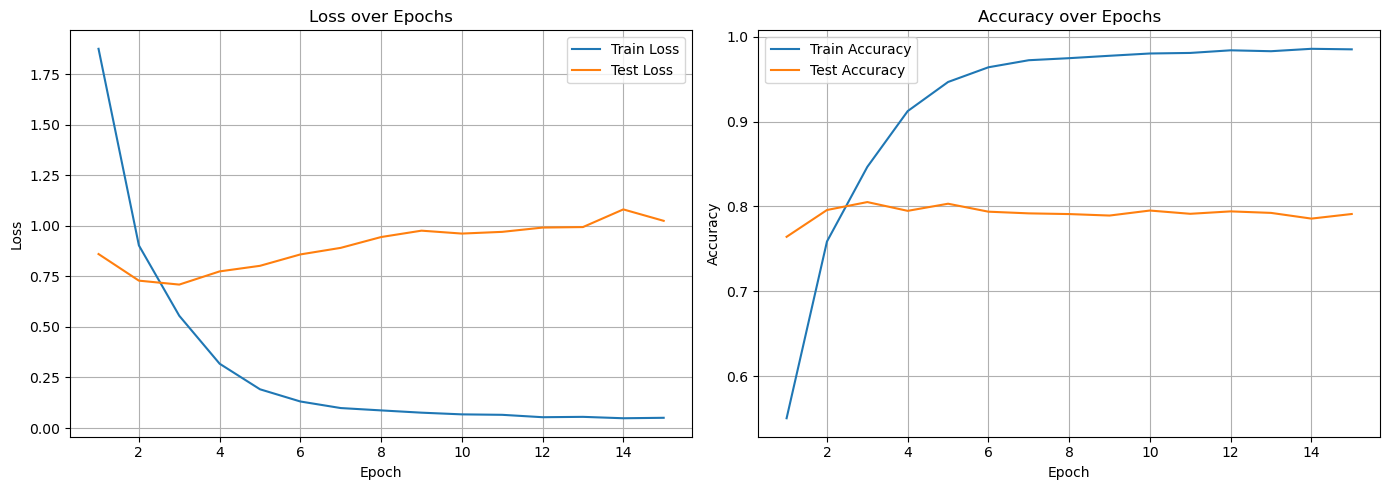

In [11]:
from modules.visualize import plot_loss_curves
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plot_loss_curves(tp2_results)

In [ ]:
save_path = 'models/model_phase02.pth'
save_model(model=model, target_path=save_path)

### Phase 3 - Progressive Fine Tuning with Layer Specific Learning Rates
##### - Unfroze 'layer3', 'layer4', and 'fc' layers.
##### - Used layer-specific learning rates:
#####     --- layer3: 1e-6
#####     --- layer4: 1e-5
#####     --- fc:     1e-4
##### - Introduced StepLR scheduler to gradually reduce learning rate every 5 epochs.
##### - Plot Loss and Accuracy Curves
##### - Goal: Allow deeper parts of the model to learn domain specific representations.
##### - Goal: Fine-tune both mid and high level feature layers for maximum accuracy while avoiding overfitting.

In [ ]:
# UnFreeze the fc layer and layer 3, 4
for name, param in model.named_parameters():
    if any(layer in name for layer in ["layer3", "layer4", "fc"]):
        param.requires_grad = True
    else:
        param.requires_grad = False

model.to(device)

tp3_optimizer = torch.optim.AdamW([
    {"params": model.layer3.parameters(), "lr": 1e-6},
    {"params": model.layer4.parameters(), "lr": 1e-5},
    {"params": model.fc.parameters(), "lr": 1e-4}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(tp3_optimizer, step_size=5, gamma=0.5)

tp3_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=20, 
                loss_fn=loss_fn, optimizer=tp3_optimizer, device=device, scheduler=scheduler)

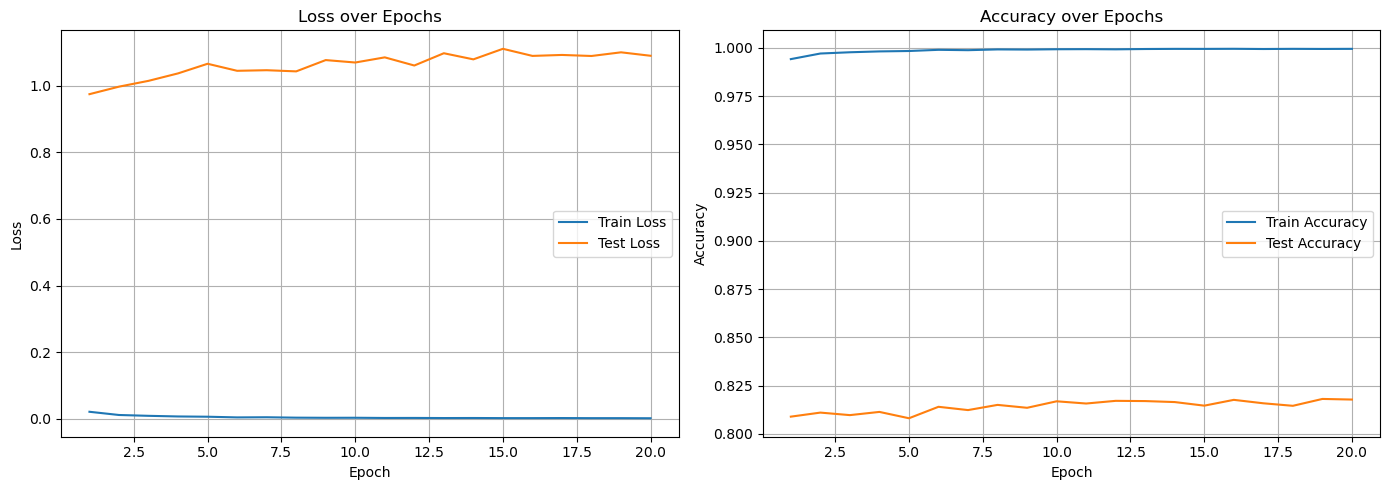

In [14]:
from modules.visualize import plot_loss_curves
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

plot_loss_curves(tp3_results)

In [ ]:
save_path = 'models/model_phase_03.pth'
save_model(model=model, target_path=save_path)